## 1. Введение

Для анализа мы будем использовать данные о гонках в классе машин Формула 1 за период с 1950 по 2017 годы.

Мы рассмотрим как развивалась данная серия гонок, динамику и структуру основных показателей, а также некоторые интересные факты.

В ходе анализа мы попытаемся найти факторы которые влияют на успешность отдельных гонщиков и команд в данных гонках.

Также мы попытаемся проанализировать зависимость успеха гонщика от его природного таланта.

Для этого в ходе исследования мы рассмотрим следующие гипотезы:

• Нулевая гипотеза H₀: Средняя позиция гонщика на финише равна средней позиции команд(как правило их несколько за карьеру) в которых он был гонщиком

• Альтернативная гипотеза H₁: Средняя позиция гонщика на финише не равна(выше) средней позиции команд в которых он был гонщиком


In [1]:
#  импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pymysql
from IPython.display import Image
from IPython.core.display import HTML
from pandas_profiling import ProfileReport
from scipy import stats as st

In [2]:
# создоаем подключение к базе данных
host = os.getenv('MYSQL_HOST')
port = os.getenv('MYSQL_PORT')
user = os.getenv('MYSQL_USER')
password = os.getenv('MYSQL_PASSWORD')
database = os.getenv('MYSQL_DATABASE')

database = os.getenv('MYSQL_DATABASE')

conn = pymysql.connect(
    host=host,
    port=int(3306),
    user="root",
    passwd='',
    db="my_db",
    charset='utf8mb4')

Созданная мною база  данных в MySQL имеет следующюю схему:

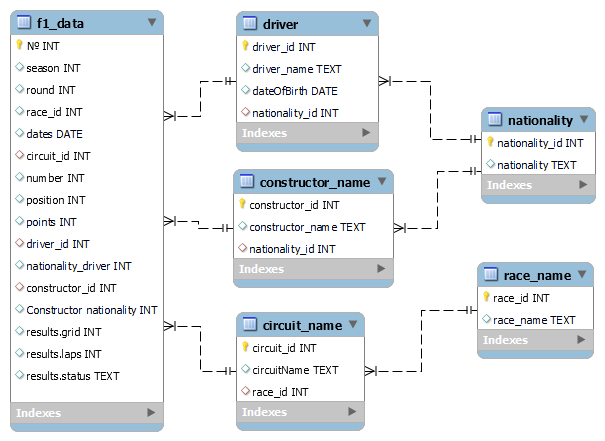

In [3]:
PATH = "data/scheme/"
Image(filename = PATH + "f1_db_scheme.png", width=600, height=600)

### Описание данных

#### Таблица F1_data

•	№ - идентификатор

•	season	-	год

•	round	-	номер гран при в сезоне

•	race_id	-	идентификатор названия гран при

•	dates	-	дата гонки

•	circuit_id	-	идентификатор названия автодрома

•	number	-	номер гонщика

•	position	-	стартовая позиция

•	points	-	полученные очки

•	driver_id	-	идентификатор имя гонщика

•	nationality_driver	-	идентификатор национальность

•	constructor_id	-	идентификатор название производителя

•	constructor nationality	-	идентификатор национальность производителя

•	results_grid	-	позиция на финише

•	results_laps	-	пройденные круги в гонке

•	results_status	-	результат

#### Таблица driver

Содержит данные:

•	driver_id	-	идентификатор имя гонщика

•	driver_name	-	имя гонщика

•	dateOfBirth	-	дата рождения

•	nationality_id	-	идентификатор национальность


#### Таблица constructor_name


•	constructor_id	-	идентификатор название производителя

•	constructor_name	-	название производителя

•	nationality_id	-	идентификатор национальность


#### Таблица nationality


•	nationality_id	-	идентификатор национальность

•	nationality	-  национальность(страна)

#### Таблица circuit_name


•	circuit_id	-	идентификатор названия автодрома

•	circuitName	-	название автодрома

•	race_id	-	идентификатор названия гран при

#### Таблица race_name


•	race_id	-	идентификатор названия гран при

•	raceName	-	название гран при

In [4]:
# загрузим основную таблицу
f1 = pd.read_sql_query("SELECT * FROM f1_data",
    conn)
f1.head()

,№,season,round,race_id,dates,circuit_id,number,position,points,driver_id,nationality_driver,constructor_id,Constructor_nationality,results_grid,results_laps,results_status
0,1,1950,1,9,1950-05-13,65,2,1,9,612,1,4,1,1,70,Finished
1,2,1950,1,9,1950-05-13,65,3,2,6,530,1,4,1,2,70,Finished
2,3,1950,1,9,1950-05-13,65,4,3,4,697,2,4,1,4,70,Finished
3,4,1950,1,9,1950-05-13,65,14,4,3,843,3,178,3,6,68,+2 Laps
4,5,1950,1,9,1950-05-13,65,15,5,2,524,3,178,3,9,68,+2 Laps


In [5]:
f1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23635 entries, 0 to 23634
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   №                        23635 non-null  int64 
 1   season                   23635 non-null  int64 
 2   round                    23635 non-null  int64 
 3   race_id                  23635 non-null  int64 
 4   dates                    23635 non-null  object
 5   circuit_id               23635 non-null  int64 
 6   number                   23635 non-null  int64 
 7   position                 23635 non-null  int64 
 8   points                   23635 non-null  int64 
 9   driver_id                23635 non-null  int64 
 10  nationality_driver       23635 non-null  int64 
 11  constructor_id           23635 non-null  int64 
 12  Constructor_nationality  23635 non-null  int64 
 13  results_grid             23635 non-null  int64 
 14  results_laps             23635 non-nul

Проверка распределения null-значений с помощью тепловой карты.

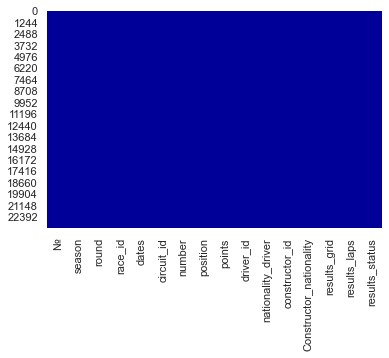

In [6]:
# желтый - пропущенные данные
colours = ['#000099', '#ffff00'] 
sns.set(font_scale=1)
sns.heatmap(f1.isnull(), cbar=False, cmap=sns.color_palette(colours))
plt.show()

## 2. Описательный анализ данных

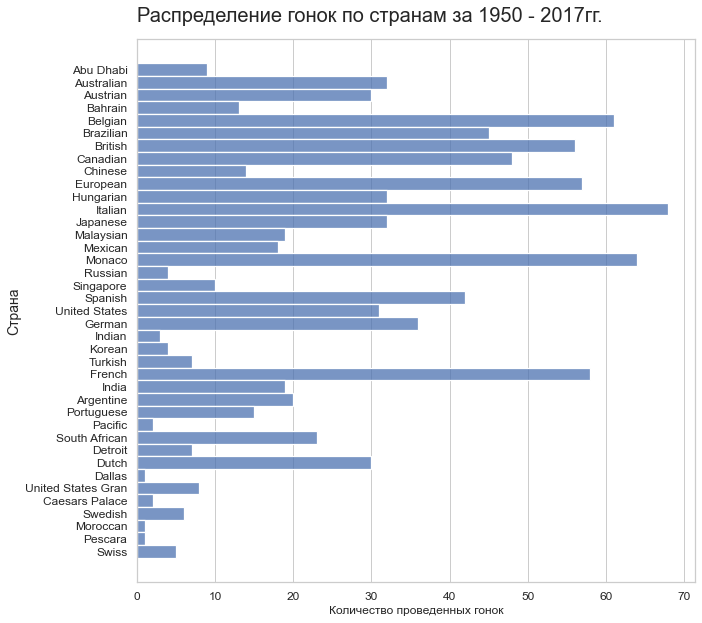

In [28]:
# посмотрим распределине количества гран при по странам
race_years = pd.read_sql_query('''
SELECT distinct race_name, YEAR(dates) as date FROM f1_data 
JOIN circuit_name ON circuit_name.circuit_id = f1_data.circuit_id 
JOIN race_name ON race_name.race_id = circuit_name.race_id 
ORDER BY date DESC
''', conn)
race_years['race_name'] = race_years['race_name'].str[:-11]

# постороим диаграмму histplot
fig, ax = plt.subplots(figsize=(10,10))
sns.histplot(data=race_years, y="race_name",palette='GnBu_r')
ax.set_title('Распределение гонок по странам за 1950 - 2017гг.',loc='left',fontsize=20, y=1.02)
ax.set_xlabel('Количество проведенных гонок')
ax.set_ylabel('Страна',fontsize = 14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
sns.set_style("whitegrid", ax.grid(axis = 'y'))
plt.show()

Как видно из диаграммы первенство по количеству проведенных гонок за данный период принадлежит Европейским странам.

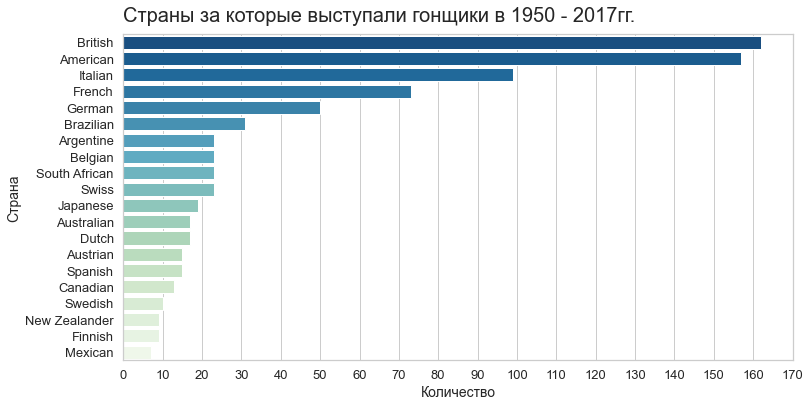

In [8]:
# страны гонщиков
nat_driv = pd.read_sql_query('''
SELECT nationality, COUNT(distinct driver_name) AS Count 
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
JOIN nationality ON nationality.nationality_id = f1_data.nationality_driver 
GROUP BY nationality 
ORDER BY Count DESC
LIMIT 20
''', conn)

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(y=nat_driv['nationality'],x=nat_driv['Count'], palette='GnBu_r')
ax.set_title('Cтраны за которые выступали гонщики в 1950 - 2017гг.',loc='left',fontsize=20, y=1.02)
ax.set_ylabel('Страна',fontsize = 14)
ax.set_xlabel('Количество',fontsize = 14)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.set_xticks(np.arange(0, 175, 10)) 
plt.show()

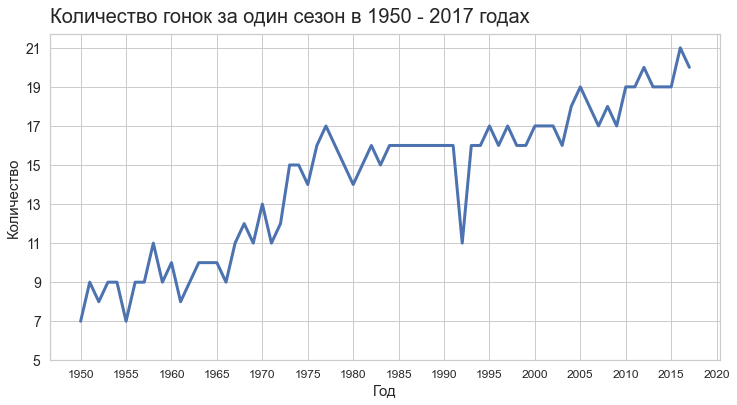

In [9]:
# посмотрим распределине количества гран при по годам
race_years = pd.read_sql_query('''
SELECT YEAR(dates) as years, COUNT(dates) as quant FROM f1_data 
JOIN circuit_name ON circuit_name.circuit_id = f1_data.circuit_id 
JOIN race_name ON race_name.race_id = circuit_name.race_id 
WHERE position = 1
GROUP BY years
ORDER BY years DESC
''', conn)

# постороим диаграмму lineplot
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(race_years['years'], race_years['quant'],linewidth = 3)
ax.set_title('Количество гонок за один сезон в 1950 - 2017 годах',loc='left',fontsize=20, y=1.02)
ax.set_ylabel('Количество',fontsize = 15)
ax.set_xlabel('Год',fontsize = 15)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=14)
ax.set_yticks(np.arange(5, 22, 2))
ax.set_xticks(np.arange(1950, 2025, 5)) 
plt.show()

Как видно из графика количество гонок выросло практически в 2 раза -  с 7 до 20.
Провал в середине 1990-х объяснится отсутствием ряда гран при в дата-сете.

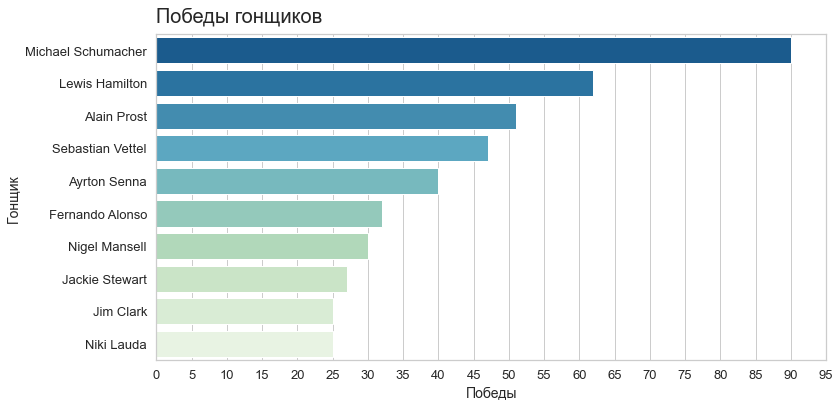

In [10]:
# все победы гонщиков 
win_driver = pd.read_sql_query('''
SELECT driver_name, COUNT(driver_name) AS wins 
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
WHERE position = 1 
GROUP BY driver_name 
ORDER BY COUNT(driver_name) DESC
LIMIT 10
''', conn)
win_driver.head()

# постороим диаграмму lineplot
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x=win_driver['wins'],y=win_driver['driver_name'], palette='GnBu_r')
ax.set_title('Победы гонщиков ',loc='left',fontsize=20, y=1.02)
ax.set_ylabel('Гонщик ',fontsize = 14)
ax.set_xlabel('Победы',fontsize = 14)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.set_xticks(np.arange(0, 100, 5)) 
plt.show()

На 2017 год М. Шумахер был безоговорочным лидером по количеству побед.

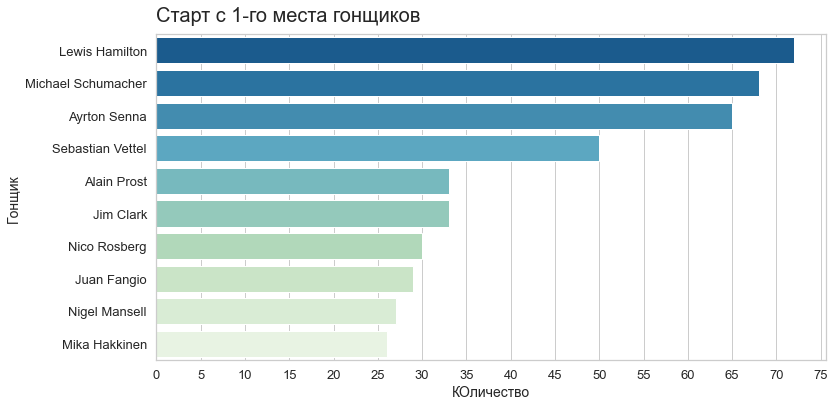

In [11]:
# все старты с 1-го места(поул-позиция) гонщиков 
pol_driver = pd.read_sql_query('''
SELECT driver_name, COUNT(driver_name) AS poles 
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
WHERE results_grid = 1 
GROUP BY driver_name 
ORDER BY COUNT(driver_name) DESC
LIMIT 10
''', conn)
pol_driver.head()

# постороим диаграмму lineplot
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x=pol_driver['poles'],y=pol_driver['driver_name'], palette='GnBu_r')
ax.set_title('Старт с 1-го места гонщиков ',loc='left',fontsize=20, y=1.02)
ax.set_ylabel('Гонщик ',fontsize = 14)
ax.set_xlabel('КОличество',fontsize = 14)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.set_xticks(np.arange(0, 80, 5)) 
plt.show()

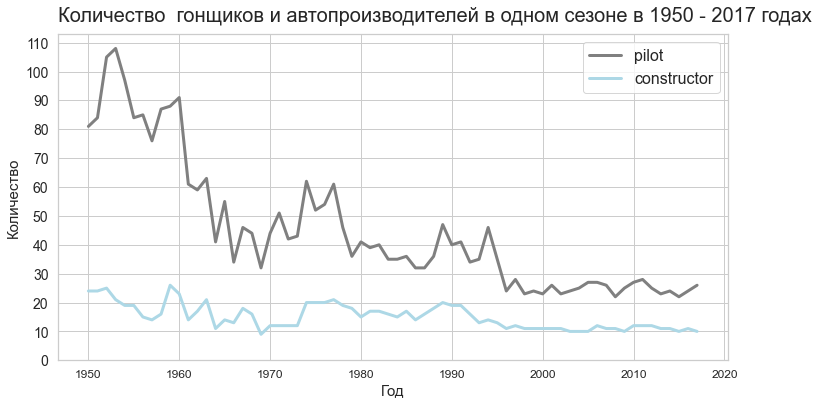

In [12]:
#  количсество разных гонщиков и автопроизводителей по годам
distinct_drivers = pd.read_sql_query('''
SELECT YEAR(dates) as years, count(distinct driver_name) as pilot, count(distinct constructor_name) as constructor 
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
JOIN constructor_name  USING(constructor_id) 
GROUP BY years 
''', conn)

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(distinct_drivers['years'], distinct_drivers['pilot'],linewidth = 3, color='grey',label='pilot')
plt.plot(distinct_drivers['years'], distinct_drivers['constructor'],linewidth = 3, color='lightblue',label='constructor')
ax.set_title('Количество  гонщиков и автопроизводителей в одном сезоне в 1950 - 2017 годах',loc='left',fontsize=20, y=1.02)
ax.set_ylabel('Количество',fontsize = 15)
ax.set_xlabel('Год',fontsize = 15)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=14)
ax.set_yticks(np.arange(0, 115, 10))
plt.legend(loc=1, prop={'size': 16})
plt.show()

В наблюдаемом периоде просматривается тенденция к снижению числа участников как со стороны гонщиков, так и со стороны автопроизводителей.

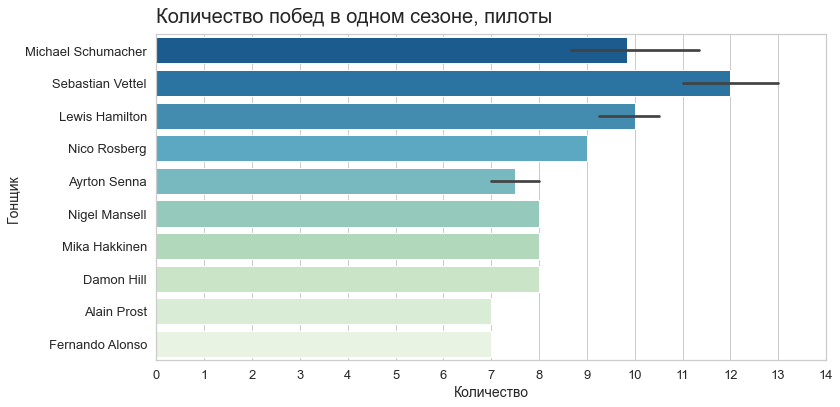

In [13]:
# количество побед в одном сезоне, пилоты
win_pil_1seas = pd.read_sql_query('''
SELECT driver_name, YEAR(dates), COUNT(dates) AS wins 
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
WHERE position = 1 
GROUP BY YEAR(dates), driver_name 
ORDER BY COUNT(driver_name) DESC
LIMIT 20
''', conn)

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x=win_pil_1seas['wins'],y=win_pil_1seas['driver_name'], palette='GnBu_r')
ax.set_title('Количество побед в одном сезоне, пилоты',loc='left',fontsize=20, y=1.02)
ax.set_ylabel('Гонщик ',fontsize = 14)
ax.set_xlabel('Количество',fontsize = 14)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.set_xticks(np.arange(0, 15, 1)) 
plt.show()

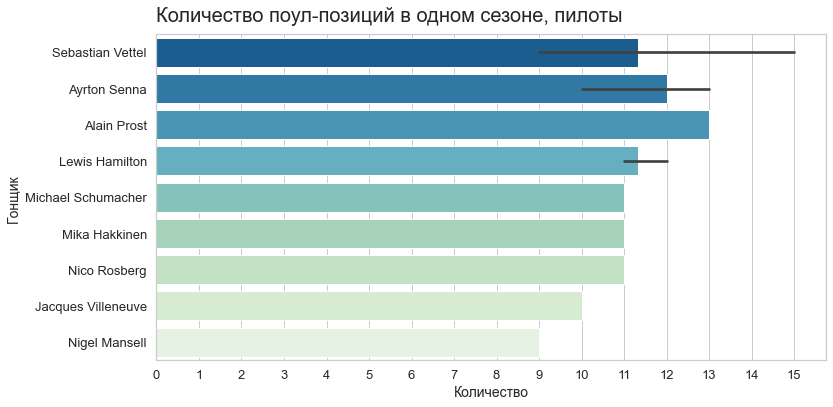

In [14]:
# количество поул-позиций в одном сезоне, пилоты
poles_pil_1seas = pd.read_sql_query('''
SELECT YEAR(dates), driver_name, COUNT(driver_name) AS poles 
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
WHERE results_grid = 1 
GROUP BY YEAR(dates), driver_name 
ORDER BY COUNT(driver_name) DESC 
LIMIT 15
''', conn)

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x=poles_pil_1seas['poles'],y=poles_pil_1seas['driver_name'], palette='GnBu_r')
ax.set_title('Количество поул-позиций в одном сезоне, пилоты',loc='left',fontsize=20, y=1.02)
ax.set_ylabel('Гонщик ',fontsize = 14)
ax.set_xlabel('Количество',fontsize = 14)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.set_xticks(np.arange(0, 16, 1)) 
plt.show()

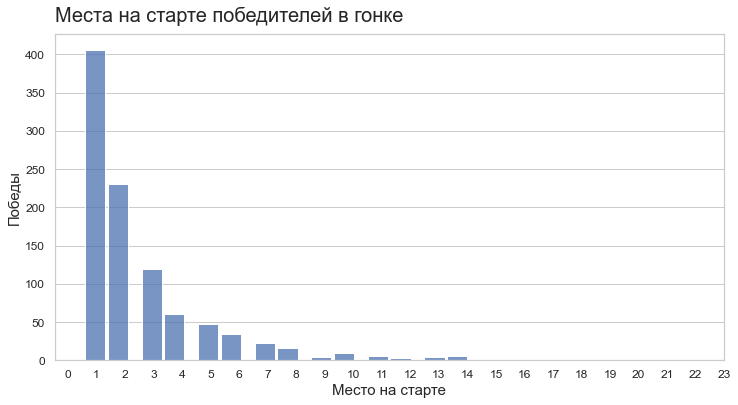

In [15]:
# победа с самого далекого места на старте
win_far = pd.read_sql_query('''
SELECT driver_name, race_name.race_name, results_grid 
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
JOIN circuit_name USING(circuit_id) 
JOIN race_name ON race_name.race_id = circuit_name.race_id 
WHERE position = 1 
ORDER BY results_grid DESC 
''', conn)
win_far.head()

# постороим диаграмму histplot
fig, ax = plt.subplots(figsize=(12,6))
sns.set_style("whitegrid", ax.grid(axis = 'x'))
sns.histplot(data=win_far, x="results_grid",palette='Blues', shrink=1.8)
ax.set_title('Места на старте победителей в гонке',loc='left',fontsize=20, y=1.02)
ax.set_ylabel('Победы',fontsize = 15)
ax.set_xlabel('Место на старте',fontsize = 15)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xticks(np.arange(0, 24, 1)) 
plt.show()

Как видно из визуализации  - победа в гонке в основном достаётся  при старте с 1 - 8 места, с 11-го места и ниже побед практически не было

In [16]:
# Возраст гонщика при 1-й победе
age = pd.read_sql_query('''
SELECT  driver_name, race_name,  datediff(dates, dateOfBirth) / 365.25 as ages, YEAR(dates) 
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
JOIN circuit_name USING(circuit_id) 
JOIN race_name ON race_name.race_id = circuit_name.race_id 
WHERE position = 1 
ORDER BY ages 
''', conn)
age.head()

,driver_name,race_name,ages,YEAR(dates)
0,Max Verstappen,Spanish Grand Prix,18.6229,2016
1,Max Verstappen,Malaysian Grand Prix,20.0027,2017
2,Max Verstappen,Mexican Grand Prix,20.0794,2017
3,Sebastian Vettel,Italian Grand Prix,21.2019,2008
4,Sebastian Vettel,Chinese Grand Prix,21.7960,2009


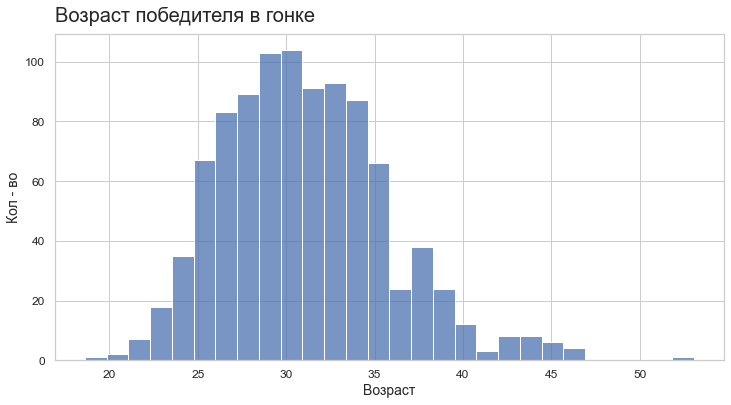

In [17]:
# постороим диаграмму histplot
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(data=age, x="ages",palette='Blues')
ax.set_title('Возраст победителя в гонке',loc='left',fontsize=20, y=1.02)
ax.set_xlabel('Возраст',fontsize = 14)
ax.set_ylabel('Кол - во',fontsize = 14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
# ax.set_yticks(np.arange(0, 25, 1)) 
plt.show()

Как видно из визуализации  - мода возраста победителя в гонке находится в районе 30 лет

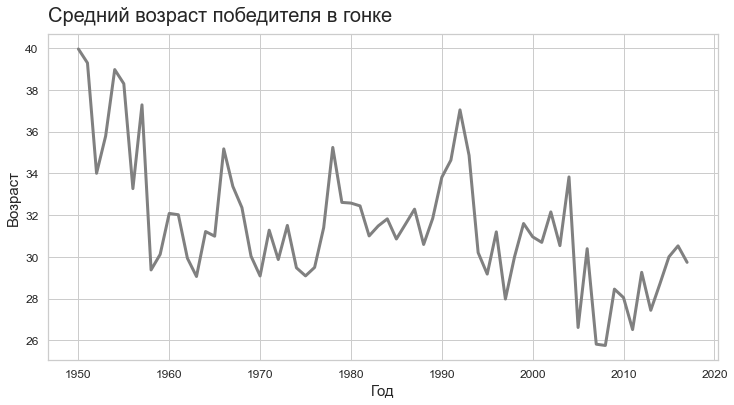

In [18]:
age_dyn = pd.read_sql_query('''
SELECT  AVG(datediff(dates, dateOfBirth) / 365.25) as ages, YEAR(dates) 
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
JOIN circuit_name USING(circuit_id) 
JOIN race_name ON race_name.race_id = circuit_name.race_id 
WHERE position = 1
GROUP BY YEAR(dates) 
ORDER BY YEAR(dates) 
''', conn)
age.head()

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(age_dyn['YEAR(dates)'],age_dyn['ages'],linewidth = 3, color='grey',label='pilot')
ax.set_title('Средний возраст победителя в гонке',loc='left',fontsize=20, y=1.02)
ax.set_ylabel('Возраст',fontsize = 15)
ax.set_xlabel('Год',fontsize = 15)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.show()

Наблюдается тенденция к снижению среднего возраста победителя в гонке

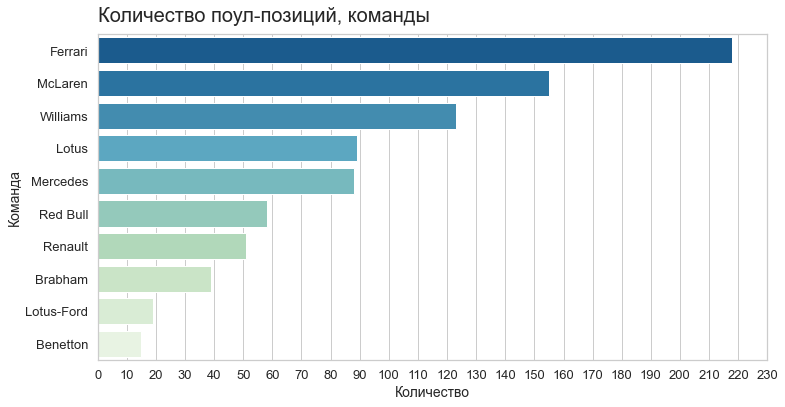

In [19]:
# constructor_poles
constructor_poles = pd.read_sql_query('''
SELECT constructor_name, COUNT(constructor_name) AS poles 
FROM f1_data 
JOIN constructor_name USING(constructor_id) 
WHERE results_grid = 1 
GROUP BY constructor_name 
ORDER BY COUNT(constructor_name) DESC
LIMIT 10
''', conn)
constructor_poles.head()

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x=constructor_poles['poles'],y=constructor_poles['constructor_name'], palette='GnBu_r')
ax.set_title('Количество поул-позиций, команды',loc='left',fontsize=20, y=1.02)
ax.set_ylabel('Команда',fontsize = 14)
ax.set_xlabel('Количество',fontsize = 14)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.set_xticks(np.arange(0, 240, 10)) 
plt.show()

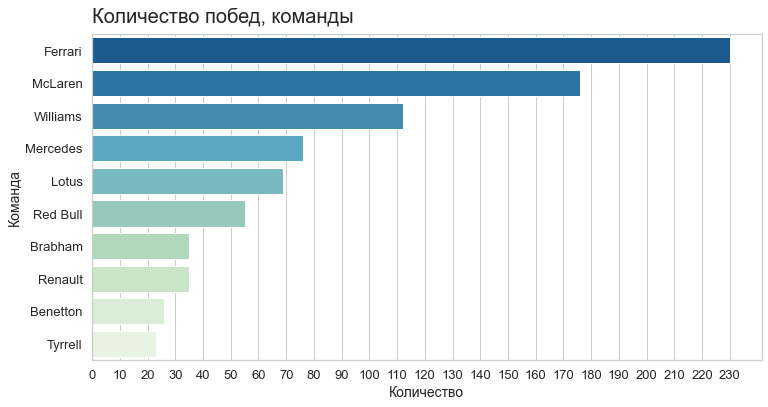

In [20]:
# constructor_wins
constructor_wins = pd.read_sql_query('''
SELECT constructor_name, COUNT(constructor_name) AS wins 
FROM f1_data 
JOIN constructor_name USING(constructor_id) 
WHERE position = 1 
GROUP BY constructor_name 
ORDER BY COUNT(constructor_name) DESC 
LIMIT 10
''', conn)

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x=constructor_wins['wins'],y=constructor_wins['constructor_name'], palette='GnBu_r')
ax.set_title('Количество побед, команды',loc='left',fontsize=20, y=1.02)
ax.set_ylabel('Команда',fontsize = 14)
ax.set_xlabel('Количество',fontsize = 14)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.set_xticks(np.arange(0, 240, 10)) 
plt.show()

Ferrari явлется лидером по общему количеству поул-позиций и побед 

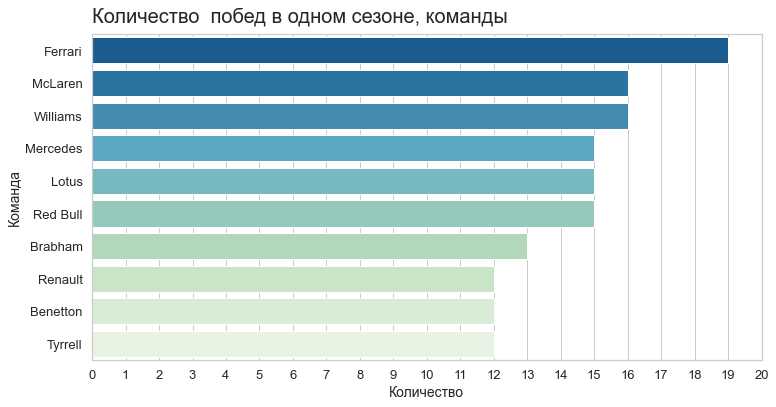

In [21]:
# количество побед в одном сезоне, команды
constr_wins_1seas = pd.read_sql_query('''
SELECT YEAR(dates),  constructor_name, COUNT(constructor_name) AS wins_constr 
FROM f1_data 
JOIN constructor_name USING(constructor_id) 
WHERE position = 1 
GROUP BY YEAR(dates),  constructor_name 
ORDER BY COUNT(constructor_name) DESC 
LIMIT 15
''', conn)

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x=constr_wins_1seas['wins_constr'],y=constructor_wins['constructor_name'], palette='GnBu_r')
ax.set_title('Количество  побед в одном сезоне, команды',loc='left',fontsize=20, y=1.02)
ax.set_ylabel('Команда',fontsize = 14)
ax.set_xlabel('Количество',fontsize = 14)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.set_xticks(np.arange(0, 21, 1)) 
plt.show()

In [22]:
# Гонщики, побеждавщие на автомобилях различных производителей
diff_constr = pd.read_sql_query('''
SELECT driver_name, count(distinct constructor_name) as constructor 
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
JOIN constructor_name  USING(constructor_id) 
WHERE position = 1 
GROUP BY driver_name 
ORDER BY constructor DESC 
''', conn)
diff_constr.head()

,driver_name,constructor
0,Stirling Moss,5
1,Alain Prost,4
2,Jackie Stewart,4
3,Juan Fangio,4
4,Carlos Reutemann,3


Есть гонщик, побеждавший на 5-ти разных автопроизводителях - возможно данный факт связан с переименованием марки авто.

In [23]:
# Процент победителей среди гонщиков и автопроизводителей (минимум 1 победа)
winn_persent = pd.read_sql_query('''
SELECT  
(SELECT COUNT(distinct driver_name) 
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
WHERE position <= 1
) as winners, 
(SELECT COUNT(distinct driver_name) 
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
)  as participants,
(SELECT winners / participants) * 100 as percent_of_winners_pilot,
(SELECT COUNT(distinct constructor_name) 
FROM f1_data 
JOIN constructor_name USING(constructor_id)  
WHERE position <= 1
) as winners_cons, 
(SELECT COUNT(distinct constructor_name) 
FROM f1_data 
JOIN constructor_name USING(constructor_id)  
)  as participants_cons,
(SELECT winners_cons / participants_cons) * 100 as percent_of_winners_constructurs
FROM f1_data 
JOIN constructor_name USING(constructor_id)
JOIN driver ON driver.driver_id = f1_data.driver_id 
LIMIT 1
''', conn)
winn_persent.head()

,winners,participants,percent_of_winners_pilot,winners_cons,participants_cons,percent_of_winners_constructurs
0,107,843,12.6928,38,197,19.2893


Процент победителей среди гонщиков логично ниже -  т.к. их количество гораздо выше, чем автопроизводителей.

## Анализ основной цели исследования
Для этого необходимо сравнить результаты на финише гонщика в данной команде и медианного значения по данной команде за весь период

In [24]:
# выберем 11 самых успешных гонщиков-чемпионов, выступавших в различные периоды времени
champions19 = pd.read_sql_query('''
SELECT driver_name, constructor_name, position 
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
JOIN constructor_name  USING(constructor_id) 
WHERE driver_name IN ('Ayrton Senna', 'Michael Schumacher', 'Alain Prost', 'Nelson Piquet','Nigel Mansell', 'Juan Fangio', 'Niki Lauda', 'Fernando Alonso','Lewis Hamilton', 'Jackie Stewart', 'Sebastian Vettel')  
''', conn)
# переименуем колонку для удобства
champions19.rename(columns={'position': 'driver_position'}, inplace=True)

# выберем все команды
consruct19 = pd.read_sql_query('''
SELECT  constructor_name, position
FROM f1_data 
JOIN driver ON driver.driver_id = f1_data.driver_id 
JOIN constructor_name  USING(constructor_id) 
''', conn)
# вычислим медиану финишной позиции по каждой команде
consruct19 = consruct19.groupby('constructor_name').median('position').sort_values('position')
# переименуем колонку для удобства
consruct19.rename(columns={'position': 'constr_med_position'}, inplace=True)
# объединим таблицы результатов гонщиков и команд
data_19 = pd.merge(champions19,consruct19,on=['constructor_name'], how='inner')
# добавим дополнительный столбец показывающий разницу между финишной позицией гонщика и команды(чем число больше - тем лучше резултат гонщика)
data_19['diff_position'] = data_19['constr_med_position'] - data_19['driver_position'] 

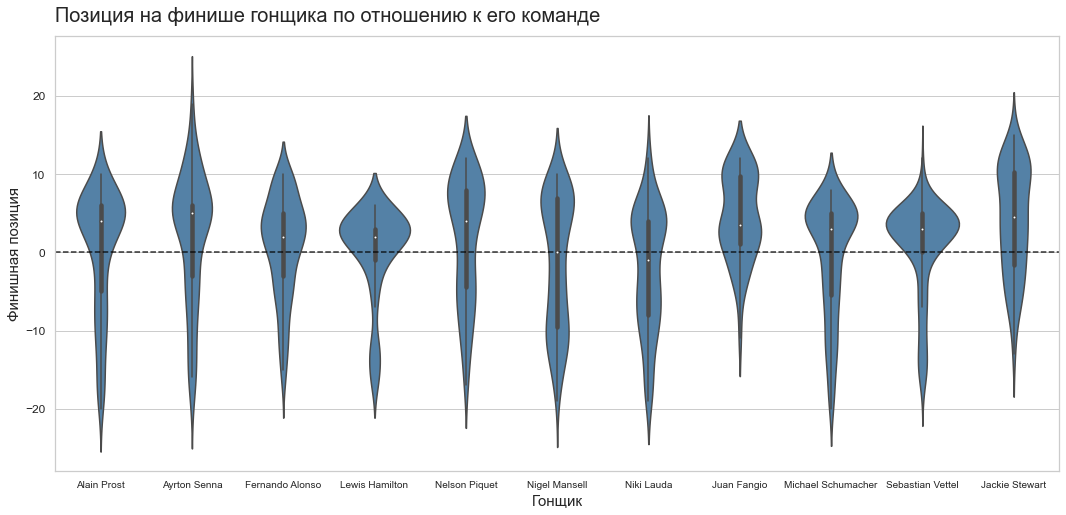

In [25]:
# постороим диаграмму violinplot
fig, ax = plt.subplots(figsize=(18,8))
sns.set_style("whitegrid")
sns.violinplot(data=data_19, x="driver_name", y="diff_position",color='steelblue')
ax.set_title('Позиция на финише гонщика по отношению к его команде',loc='left',fontsize=20, y=1.02)
ax.set_ylabel('Финишная позиция',fontsize = 15)
ax.set_xlabel('Гонщик',fontsize = 15)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=12)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.8) 
plt.show()

### Анализ визуализации:

Основная часть позиций на финише у 9-ти из 11-ти гонщиков выше командной на 4-10 позиций.

При этом:

•	у Ayrton Senna - одно из лучших медианных значений т.е. он финишировал выше на 5 позиций, а также есть  финиши с превышением уровня команды на + 20 позиций

•	Juan Fangio – практически всегда финишировал выше, чем команда  - все финишные места по 25-75 квартилям выше минимум на 1 позицию, но при этом  медиана хуже, чем у Ayrton Senna

•	Jackie Stewart - также показывает один из лучших результатов по медиане и 25-75 квартилям

•	у Nigel Mansell, Niki Lauda, Lewis Hamilton – больше всех финишей, хуже чем среднее значение по команде.

•	похожие графики по  распределению, форме  у Lewis Hamilton и Sebastian Vettel 

Особенно выделяются:

•	Lewis Hamilton – основная часть результатов отличная и приближается к лучшим в это исследовании, однако имеются финиши на в рамках 10-20 позиций хуже, чем по команде, учитывая тот факт, что он выступал только в двух командах (McLaren, Mercedes), являющихся топ-командами - это заставляет задуматься о стабильности результатов данного гонщика.

•	Nigel Mansell и Niki Lauda -  довольно много результатов на 10-20 позиций хуже, чем по команде, а также медиана(у Niki Lauda) меньше 0 или равная 0 (у Nigel Mansell). Данных гонщиков довольно сложно назвать обычными среднестатистическими, однако на фоне остальных участников исследования их результаты выглядят слабее.

### Проверка гипотезы

В ходе исследования мы сформировали следующие гипотезы:

• Нулевая гипотеза H₀: Средняя позиция гонщика на финише равна средней позиции команд(как правило их несколько за карьеру) в которых он был гонщиком

• Альтернативная гипотеза H₁: Средняя позиция гонщика на финише не равна(выше) средней позиции команд, в которых он был гонщиком

Так как мы сравниваем два средних из двух выборок, из библиотеки scipy подбираем метод ttest_ind(), если обе выборки имеют нормальное распределение.
Если хоть одна из двух выборок нормального распределения не имеет, используем метод Манна-Уитни. 

Чтобы понять нормальное распределение имеют выборки или нет, используем для обеих критерий Шапиро.

In [26]:
# используем критерий Шапиро
alpha = 0.01

list_1 =['Ayrton Senna', 'Michael Schumacher', 'Alain Prost', 'Nelson Piquet','Nigel Mansell','Juan Fangio', 'Niki Lauda', 'Fernando Alonso', 'Lewis Hamilton', 'Jackie Stewart', 'Sebastian Vettel']  
for i in list_1:
    user_score_for_1 = data_19[data_19['driver_name'] == i]['driver_position'].dropna()
    results = st.shapiro(user_score_for_1)
    if (results[1] < alpha):
        print('Распределение не нормальное', i)
    else:
        print("Распределение нормальное", i)   


Распределение не нормальное Ayrton Senna
Распределение не нормальное Michael Schumacher
Распределение не нормальное Alain Prost
Распределение не нормальное Nelson Piquet
Распределение не нормальное Nigel Mansell
Распределение не нормальное Juan Fangio
Распределение не нормальное Niki Lauda
Распределение не нормальное Fernando Alonso
Распределение не нормальное Lewis Hamilton
Распределение не нормальное Jackie Stewart
Распределение не нормальное Sebastian Vettel


Т.к. все распределения не нормальны для проверки гипотезы возьмем критерий Манна-Уитни.

In [27]:
list_1 =['Ayrton Senna', 'Michael Schumacher', 'Alain Prost', 'Nelson Piquet','Nigel Mansell','Juan Fangio', 'Niki Lauda', 'Fernando Alonso', 'Lewis Hamilton', 'Jackie Stewart', 'Sebastian Vettel']  
for i in list_1:
    user_score_for_1 = data_19[data_19['driver_name'] == i]['driver_position'].dropna()
    user_score_for_2 = data_19['constr_med_position'].dropna()
    results = st.mannwhitneyu(user_score_for_1, user_score_for_2)
    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу", i, results.pvalue)
    else:
        print("Не получилось отвергнуть нулевую гипотезу", i, results.pvalue)

Отвергаем нулевую гипотезу Ayrton Senna 5.2937188466112874e-08
Отвергаем нулевую гипотезу Michael Schumacher 2.5925224494709847e-24
Отвергаем нулевую гипотезу Alain Prost 2.0378954302985573e-15
Не получилось отвергнуть нулевую гипотезу Nelson Piquet 0.1326773011184093
Не получилось отвергнуть нулевую гипотезу Nigel Mansell 0.010685810500008977
Отвергаем нулевую гипотезу Juan Fangio 6.32368348420265e-12
Не получилось отвергнуть нулевую гипотезу Niki Lauda 0.028011737393232317
Отвергаем нулевую гипотезу Fernando Alonso 1.525919632901161e-09
Отвергаем нулевую гипотезу Lewis Hamilton 1.5612686109817893e-42
Отвергаем нулевую гипотезу Jackie Stewart 4.028669863936217e-05
Отвергаем нулевую гипотезу Sebastian Vettel 5.430880959843082e-34


## 3.  Выводы:

В ходе исследования мы рассмотрели динамику и структуру основных показателей по командам и гонщикам, а также некоторые интересные факты.

Нулевую гипотезу H₀: Средняя позиция гонщика на финише равна средней позиции команд(как правило их несколько за карьеру) в которых он был гонщиком не получилось отклонить только в 3 случаях из 11.

В целом результаты проверки гипотезы как  минимум по 2 гонщикам(Nigel Mansell, Niki Lauda) соответствуют визуализации, что может служить признаком верного расчета.

Таким образом, цель исследования можно считать достигнутой - доказано, что талант все же является одним из важных факторов успеха гонщика.